In [26]:
import tensorflow as tf
import time
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)

In [2]:
import tarfile
import re
import urllib.request
import os
import random

class ImdbMovieReviews:
    DEFAULT_URL = \
        'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    TOKEN_REGEX = re.compile(r'[A-Za-z]+|[!?.:,()]')
    
    def __init__(self):
        self._cache_dir = './imdb'
        self._url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
        
        if not os.path.isfile(self._cache_dir):
            urllib.request.urlretrieve(self._url, self._cache_dir)
        self.filepath = self._cache_dir

    def __iter__(self):
        with tarfile.open(self.filepath) as archive:
            items = archive.getnames()
            for filename in archive.getnames():
                if filename.startswith('aclImdb/train/pos/'):
                    yield self._read(archive, filename), True
                elif filename.startswith('aclImdb/train/neg/'):
                    yield self._read(archive, filename), False
                    
    def _read(self, archive, filename):
        with archive.extractfile(filename) as file_:
            data = file_.read().decode('utf-8')
            data = type(self).TOKEN_REGEX.findall(data)
            data = [x.lower() for x in data]
            return data

In [3]:
import numpy as np
# Spacy is my favourite nlp framework, which havu builtin word embeddings trains on wikipesia
from spacy.en import English

class Embedding:
    
    def __init__(self):
#          spaCy makes using word vectors very easy. 
#             The Lexeme , Token , Span  and Doc  classes all have a .vector property,
#             which is a 1-dimensional numpy array of 32-bit floats:
        self.parser = English()
#         self._length = length
        self.dimensions = 300
        
    def __call__(self, sequence, length):
        # DO I really need them to be equal length?
        # Let's assume I'm not
        data = np.zeros((length, self.dimensions))
        # you can access known words from the parser's vocabulary
        embedded = [self.parser.vocab[w].vector for w in sequence]
        data[:len(sequence)] = embedded
        return data

In [4]:
import itertools

def preprocess_batched_split(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch = []
        labelss = []
        sentence_sizes_batch = []
        for index in range(batch_size):
            text, label = next(iterator)
            sents = [list(y) for x, y in itertools.groupby(text, lambda z: z == '.') if not x]
            sentence_sizes = [len(s) for s in sents]
            text_embed = [embedding(sent) for sent in sents]
            
            batch.append(text_embed)
            labelss.append(label)
            sentence_sizes_batch.append(sentence_sizes)
            
        labels_batch = np.array(labelss, dtype=np.int32)
        sent_per_doc = np.array([len(x) for x in sentence_sizes_batch])
        words_per_sent_per_doc = np.array(sentence_sizes_batch)
        yield np.array(batch), labels_batch, words_per_sent_per_doc, sent_per_doc

In [5]:
import itertools

def preprocess_batched_split2(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch, labels_b = zip(*itertools.islice(iterator, batch_size))
        
        sents_b = [[list(y) for x, y in itertools.groupby(doc, lambda z: z == '.') if not x] for doc in batch]

        sentence_sizes_b = [[len(sent) for sent in doc] for doc in sents_b]
        sentence_size = max(map(max, sentence_sizes_b))
        
        document_sizes = np.array([len(doc) for doc in sentence_sizes_b], dtype=np.int32)
        document_size = document_sizes.max()

        sentence_sizes_np = np.zeros(shape=[batch_size, document_size], dtype=np.int32)
        for bi, ds, ss in zip(range(sentence_sizes_np.shape[0]), document_sizes, sentence_sizes_b):
            sentence_sizes_np[bi][:ds] = ss
        
        text_embed_b = np.zeros((batch_size, document_size, sentence_size, 300))
        for i, ds, doc_sents in zip(range(text_embed_b.shape[0]), document_sizes, sents_b):
            doc_sents_embed = np.array([embedding(sent, sentence_size) for sent in doc_sents])
            text_embed_b[i][:ds] = doc_sents_embed
        
        yield text_embed_b, np.array(labels_b, dtype=np.int32), np.array(document_sizes), sentence_sizes_np, sents_b

In [6]:
reviews = list(ImdbMovieReviews())

In [7]:
random.shuffle(reviews)

In [8]:
#################################################

In [9]:
%load_ext autoreload
%autoreload 1
%aimport HanSequenceLabellingModel, model_components
%aimport

Modules to reload:
HanSequenceLabellingModel model_components

Modules to skip:



In [15]:
batches_split = preprocess_batched_split2(reviews, Embedding(), batch_size=10)

In [11]:
from HanSequenceLabellingModel import HanSequenceLabellingModel

In [12]:
def HAN_model_1(session, restore_only=False):
    """Hierarhical Attention Network"""
    import tensorflow as tf
    try:
        from tensorflow.contrib.rnn import GRUCell, MultiRNNCell, DropoutWrapper
    except ImportError:
        MultiRNNCell = tf.nn.rnn_cell.MultiRNNCell
        GRUCell = tf.nn.rnn_cell.GRUCell
    from bn_lstm import BNLSTMCell
    from HanSequenceLabellingModel import HanSequenceLabellingModel

    is_training = tf.placeholder(dtype=tf.bool, name='is_training')

    cell = BNLSTMCell(80, is_training) # h-h batchnorm LSTMCell
    cell = MultiRNNCell([cell]*5)

    model = HanSequenceLabellingModel(
            embedding_size=300,
            classes=2,
            word_cell=cell,
            sentence_cell=cell,
            word_output_size=300,
            sentence_output_size=300,
            learning_rate=0.001,
            max_grad_norm=5.0,
            dropout_keep_proba=0.5,
            is_training=is_training,
    )

    saver = tf.train.Saver(tf.global_variables())
    checkpoint_dir = 'checkpoints'
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint:
        print("Reading model parameters from %s" % checkpoint.model_checkpoint_path)
        saver.restore(session, checkpoint.model_checkpoint_path)
    elif restore_only:
        raise FileNotFoundError("Cannot restore model")
    else:
        print("Created model with fresh parameters")
        session.run(tf.global_variables_initializer())
        
    return model, saver

In [103]:
from __future__ import print_function
from colors import color

tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)

    for data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_b in batches_split:

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        word_attention, sentence_attention = s.run([model.word_attention, model.sentence_attention], feed_dict=fd)
        max_len = sentence_attention.shape[1]
        
        for i, review in enumerate(sents_b):
            for j, sentence in enumerate(review): 
                capacity = 255 - int(255 * sentence_attention[i, j, 0] / np.max(sentence_attention[i]))
                print(color('   ', 'black', '#ff{cap:02x}{cap:02x}'.format(cap=capacity)), end=' ')
                for k, word in enumerate(sentence):
                    capacity = 255 - int(100 * word_attention[i * max_len + j, k, 0] / \
                                         np.max(word_attention[i * max_len + j]))
                    print(color(word, 'black', '#{cap:02x}{cap:02x}ff'.format(cap=capacity)), end=' ')
                print()
            print()
            break
        break

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400
    i have to admit that tsui hark is one of a kind , you can t top a person with a strong style of movie presence 
    a chinese fantasy picture may not be easy to present to an audience , the director attempted to bring back the classic fantasy tales of zu mountain and this is what he displayed 
    br br the new legend of zu has truly improved from the one in 
    from this new millenium update , we could see tsui hark s vision of the zu mountains 
    spectacular visual designs , amazing action fantasy epic made beautifully well 
    kept me glued through the entire picture 
    great cast with just fine acting 
    it s truly a fun movie to watch , but is it too weird ? br br now the down side is people will definitely get confused with it s broad story line shortened down into a minute movie 
    plot may not have much relation among characters , but by 

In [ ]:
#           label:  '0', '1'
attention_values = [[[], []], # 'good'
                    [[], []]] # 'bad'

In [ ]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

word_ind = lambda word: 0 if word == 'good' else 1 if word == 'bad' else False

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)

    for t, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_b) in enumerate(batches_split):
        
        if t > 500:
            break
        
        print(t)

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        word_attention = s.run(model.word_attention, feed_dict=fd)
        max_len = int(word_attention.shape[0] / len(sents_b))
        
        for i, review in enumerate(sents_b):
            for j, sentence in enumerate(review): 
                for k, word in enumerate(sentence):
                    x = word_ind(word)
                    if type(x) == int:
                        attention_values[x][int(labels_batch[i])].append(word_attention[i * max_len + j, k, 0])

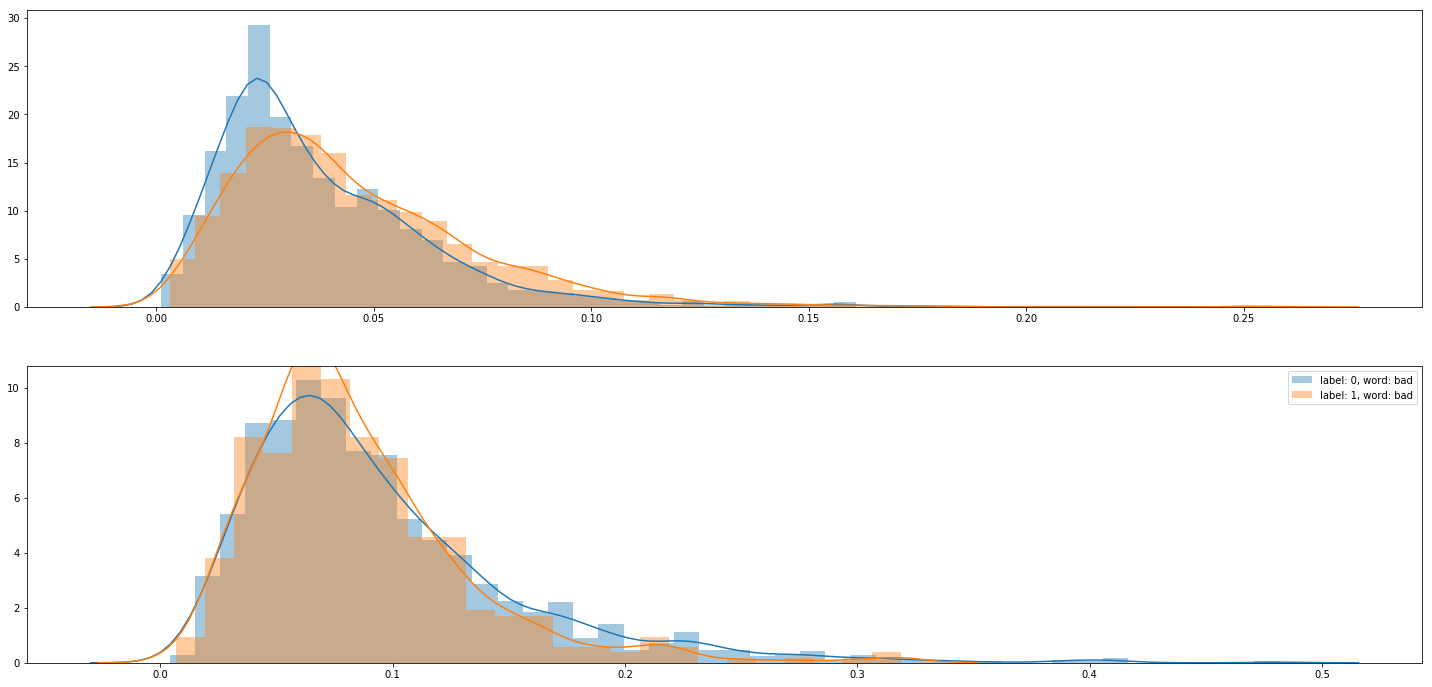

In [30]:
fig, axs = plt.subplots(nrows=2, figsize=(25, 12))

for x in range(2):
    for y in range(2):
        sns.distplot(attention_values[x][y], ax=axs[x],
                     label='label: {l}, word: {w}'.format(l=y, w='good' if x == 0 else 'bad'))
plt.legend()